##  Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you have learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

###  Dataset

You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits (This is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset). The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. We use the `.mat` format here because this is the dataset provided in the MATLAB version of this assignment. Fortunately, python provides mechanisms to load MATLAB native format using the `loadmat` function within the `scipy.io` module. This function returns a python dictionary with keys containing the variable names within the `.mat` file. 

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
We start the exercise by first loading the dataset. Execute the cell below, you do not need to write any code here.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat



In [48]:
# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10 in dataset)
num_labels = 10

path = "/Users/hassaanmuzammil/Downloads/ml-coursera-python-assignments-master/Exercise3/Data/ex3data1.mat"
#  training data stored in arrays X, y
data = loadmat(path)
X = data["X"]
y = data["y"]
m = y.size

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
# y[y == 10] = 0

print(X.shape)
print(y.shape)
print(m)


(5000, 400)
(5000, 1)
5000


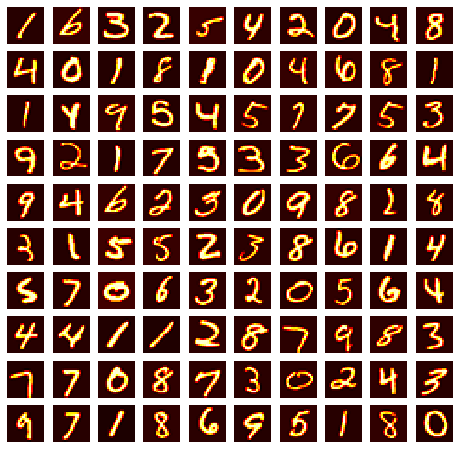

In [3]:
#Visualizing some of the images
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"),cmap="hot") #reshape back to 20 pixel by 20 pixel
        #order = 'F' ensures upright images
        axis[i,j].axis("off")
        

<a id="section1"></a>
####  Vectorizing the cost function 

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Then, by computing the matrix product $X\theta$, we have: 

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

####  Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_\theta\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

The expression above allows us to compute all the partial derivatives
without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. 

Your job is to write the unregularized cost function `lrCostFunction` which returns both the cost function $J(\theta)$ and its gradient $\frac{\partial J}{\partial \theta}$. Your implementation should use the strategy we presented above to calculate $\theta^T x^{(i)}$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

<div class="alert alert-box alert-warning">
**Debugging Tip:** Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the `shape` property of `numpy` arrays. For example, given a data matrix $X$ of size $100 \times 20$ (100 examples, 20 features) and $\theta$, a vector with size $20$, you can observe that `np.dot(X, theta)` is a valid multiplication operation, while `np.dot(theta, X)` is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.
</div>
<a id="lrCostFunction"></a>

In [4]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    return 1/ (1 + np.exp(-z))

def cost_lr(theta, X, y, Lambda):
    """
    Takes in numpy array of theta, X, y, and float lambda to compute the regularized logistic cost function 
    """
    m = y.size
    predictions = sigmoid(X @ theta)
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost = cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # compute gradient
    j_0 = 1/m * (X.transpose() @ (predictions - y))[0]
    j_1 = 1/m * (X.transpose() @ (predictions - y))[1:] + (Lambda/m)* theta[1:]
    grad = np.vstack((j_0[:,np.newaxis],j_1))
    return regCost[0], grad
    
    

### Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops. You can use your code in the previous exercise as a starting point for this exercise. 

To test your vectorized logistic regression, we will use custom data as defined in the following cell.

In [6]:
#Test case
theta_t = np.array([-2,-1,1,2]).reshape(4,1)
#print("Theta: \n",theta_t)
X_t = np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T
X_t = np.hstack((np.ones((5,1)), X_t))
#print("X: \n",X_t)
y_t = np.array([1,0,1,0,1]).reshape(5,1)
#print("y: \n",y_t)
J, grad = cost_lr(theta_t, X_t, y_t, 3)

print("Cost:",J,"\nExpected cost: 2.534819")
print("Gradients:\n",grad,"\nExpected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")

Cost: 2.534819396109744 
Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


In [7]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    m = len(y)
    J_history = []
    
    for i in range(num_iters):
        cost, grad = cost_lr(theta,X,y,Lambda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    
    return theta , J_history

In [8]:
theta_test, J_test = gradientDescent(X_t,y_t,theta_t,0.1,300,1)

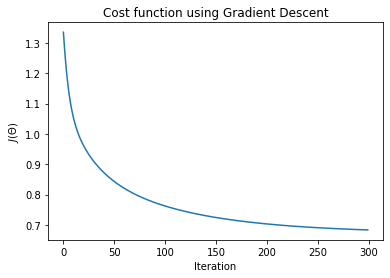

In [9]:
#Visualizing test case cost history
plt.plot(J_test[0:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.show()

### One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$. 

You should now complete the code for the function `oneVsAll` below, to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\theta \in \mathbb{R}^{K \times (N +1)}$, where each row of $\theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a “for”-loop from $0$ to $K-1$, training each classifier independently.

Note that the `y` argument to this function is a vector of labels from 0 to 9. When training the classifier for class $k \in \{0, ..., K-1\}$, you will want a K-dimensional vector of labels $y$, where $y_j \in 0, 1$ indicates whether the $j^{th}$ training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a different
class $(y_j = 0)$. You may find logical arrays helpful for this task. 

Furthermore, you will be using scipy's `optimize.minimize` for this exercise. 
<a id="oneVsAll"></a>

In [10]:
def oneVsAll(X, y, num_labels, Lambda):
    """
    Takes in numpy array of X,y, int num_labels and float lambda to train multiple logistic regression classifiers
    depending on the number of num_labels using gradient descent. 
    
    Returns a matrix of theta, where the i-th row corresponds to the classifier for label i
    """
    m, n = X.shape[0], X.shape[1]
    initial_theta = np.zeros((n+1,1))
    all_theta = []
    all_J = []
    # add intercept terms
    
    X = np.hstack((np.ones((m,1)),X))
    
    for i in range(1,num_labels+1):
        theta , J_history = gradientDescent(X,np.where(y==i,1,0),initial_theta,1,300,Lambda)
        all_theta.extend(theta)
        all_J.extend(J_history)
    return np.array(all_theta).reshape(num_labels,n+1), all_J

theta_test, J_test = oneVsAll(X,y,10,1)

In [11]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of X(i) for each class and predict the label
    
    return a vector of prediction
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    predictions = X @ all_theta.T
    return np.argmax(predictions,axis=1)+1

pred = predictOneVsAll(theta_test, X)
print("Predicted Values: ",pred)
print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")


Predicted Values:  [10 10 10 ...  9  9  7]
Training Set Accuracy: 91.42 %


## Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier (You could add more features - such as polynomial features - to logistic regression, but that can be very expensive to train).

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters. 

We start by first reloading and visualizing the dataset which contains the MNIST handwritten digits (this is the same as we did in the first part of this exercise, we reload it here to ensure the variables have not been modified). 


### Model representation 

Our neural network is shown in the following figure.

![Neural network](Figures/neuralnetwork.png)

It has 3 layers: an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y. 

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in `ex3weights.mat`. The following cell loads those parameters into  `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

###  Feedforward Propagation and Prediction

Now you will implement feedforward propagation for the neural network. You will need to complete the code in the function `predict` to return the neural network’s prediction. You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $\left( h_\theta(x) \right)_k$.


In [50]:
#Loading optimized weights from mat file
path2 = "/Users/hassaanmuzammil/Downloads/ml-coursera-python-assignments-master/Exercise3/Data/ex3weights.mat"
data2 = loadmat(path2)
Theta1 = data2["Theta1"] # Theta1 has size 25 x 401
Theta2 = data2["Theta2"] # Theta2 has size 10 x 26
print(Theta1.shape)
print(Theta2.shape)
parameters = np.append(Theta1.flatten(),Theta2.flatten())
print(parameters.shape)

(25, 401)
(10, 26)
(10285,)


In [31]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network by feedforward Propagation
    """
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    return np.argmax(a2,axis=1)+1

pred2 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")
print(pred2)

Training Set Accuracy: 97.52 %
[10 10 10 ...  9  9  9]


In [32]:
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<a id="section1"></a>
###  Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows (i.e., X[i,:] is the i-th training example $x^{(i)}$, expressed as a $n \times 1$ vector.) When you complete the code in `nnCostFunction`, you will need to add the column of 1’s to the X matrix. The parameters for each unit in the neural network is represented in Theta1 and Theta2 as one row. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.
</div>
<a id="nnCostFunction"></a>

<a id="section2"></a>
### Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we
have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size. Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing `nnCostFunction` and then later add the cost for the regularization terms.

[Click here to go back to `nnCostFunction` for editing.](#nnCostFunction)

In [33]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 (25 x 401) and Theta2 (10 x 26)
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J = 0 
    X = np.hstack((np.ones((m,1)),X))  # 5000 x 401
    y10 = np.zeros((m,num_labels)) # 5000 x 10

    a1 = sigmoid(X @ Theta1.T) 
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer 5000 x 26
    a2 = sigmoid(a1 @ Theta2.T) # output layer 5000 x 10

    
    #Convert y (5000,1) to y10 (5000,10) consisting of 0's and 1's 
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = (1/m) * J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi = X[i,:] # 401 x 1
        a1i = a1[i,:] # 1 x 26
        a2i = a2[i,:] # 1 x 10
        
        d2 = a2i - y10[i,:] # 1 x 10
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T))) # 26 x 26
        #print(d1.shape)
        #print(d2.shape)
        grad1 = grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T # 25 x 401
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T # 10 x 26
        #print(grad1.shape)
        #print(grad2.shape)
    grad1 = (1/m) * grad1
    grad2 = (1/m) * grad2

    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg

In [42]:
xi_ = np.ones([401,])
print(xi_.shape)
a1i_ = np.ones([1,26])
a2i_ = np.ones([1,10])
y1_ = np.ones([1,10])*2
d2_ = a2i_ - y1_
t2 = np.ones([10,26])
t1 = np.ones([25,401])
b = np.hstack((1,xi_@(t1.T)))
print(b.shape)
d1_ = t2.T @ d2_.T * sigmoidGradient(b)
print(d1_.shape)
print(d2_.shape)
#c = (d1_[1:][:,np.newaxis]) @ (xi_[:,np.newaxis].T)
#print(c.shape)
print((d2_.T * sigmoidGradient(b)).shape)
print((d1_[1:][:,np.newaxis]).shape) 
print((xi_[:,np.newaxis].T).shape)
print((d2_.T[:,np.newaxis]).shape)
print((a1i_[:,np.newaxis].T).shape)

(401,)
(26,)
(26, 26)
(1, 10)
(10, 26)
(25, 1, 26)
(1, 401)
(10, 1, 1)
(26, 1, 1)


In [43]:
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.append(Theta1.flatten(),Theta2.flatten())
J,reg_J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)[0:4:3]
print("Cost (non-regularized) at initial parameters:",J,"\nCost (Regularized) at initial parameters:",reg_J)

Cost (non-regularized) at initial parameters: 0.2876291651613188 
Cost (Regularized) at initial parameters: 0.38376985909092354


In [44]:
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid)

In [45]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6 / (L_in+L_out)) 
    print(np.sqrt(epi))
    W = (np.random.rand(L_out,L_in+1)+np.random.randint(0,5))*(2*epi) -epi
    return W

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.T.flatten(),initial_Theta2.T.flatten())
#print(initial_Theta1)


0.11881770515720091
0.4140393356054125


In [51]:
print(initial_Theta1.shape)
print(initial_Theta2.shape)
print(initial_nn_params.shape)
pred4 = predict(initial_Theta1, initial_Theta2, X)
print("Training Set Accuracy:",sum(pred4[:,np.newaxis]==y)[0]/5000*100,"%")

(25, 401)
(10, 26)
(10285,)
Training Set Accuracy: 10.0 %


(25, 401)
(25, 401)
0.5342286316691767


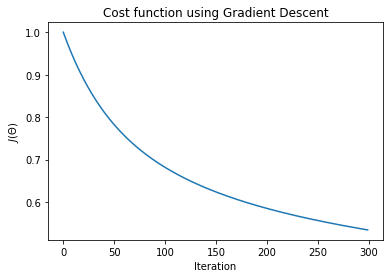

In [53]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    T1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    print(T1.shape)
    T2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    print(T1.shape)
    
    m = len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params_1 = np.append(T1.flatten(),T2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params_1,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        T1 = T1 - (alpha * grad1)
        T2 = T2 - (alpha * grad2)
        J_history.append(cost)
        #print(T1[0][0])
    
    nn_paramsFinal = np.append(T1.flatten(),T2.flatten())
    #print(J_history[-1])
    return nn_paramsFinal , J_history

nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,1.6,400,1,input_layer_size, hidden_layer_size, num_labels)
plt.plot(nnJ_history[100:400])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
final_Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
final_Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
#print(Theta1)
print(min(nnJ_history))



In [54]:
pred5 = predict(final_Theta1, final_Theta2, X)
print("Training Set Accuracy:",sum(pred5[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 94.22 %


In [721]:
X.shape

(5000, 400)

In [722]:
X[1,:].shape

(400,)